In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
This to apply Kalman Fitler

The measurements in the kalman filter are:
latitude, longitude, gps_speed

@author: 
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise


def calculate_distance(lat_start, lon_start, lat_end, lon_end, unit="km"):
    """
    Calculate distance using lat lon based on Haversine formula.
    Attr:
    lat_start - start location latitude vector
    lon_start - start location longitude vector
    lat_end - end location latitude vector
    lon_end - end location longitude vector
    unit - unit of distance, "mile" and "km" supported
    Return:
    distance vector.
    """
    error_msg = "The unit for distance has to be one of mile and km"
    if unit not in ['mile', 'km']:
        raise ValueError(error_msg)
    elif unit == "mile":
        r = 3959.
    elif unit == "km":
        r = 6371.
    lat_start = np.radians(lat_start)
    lon_start = np.radians(lon_start)
    lat_end = np.radians(lat_end)
    lon_end = np.radians(lon_end)
    anglescossin = np.sin(lat_start)*np.sin(lat_end) \
                        + np.cos(lat_start)*np.cos(lat_end) \
                        * np.cos(lon_end - lon_start)
    anglescossin = np.clip(anglescossin,a_min=-1.0,a_max=1.0)
    d_angle = np.arccos(anglescossin)
    distance_ = r * d_angle
    return distance_


def add_speed(gpsdf):
    """
    This function is just a temp function for the display below, not really useful
    """
    lat_var = "gps_lat"
    lon_var = "gps_lon"
    time_var = "timestamp"
    gpsdf[lat_var+'_last'] = gpsdf[lat_var].shift(1).copy()
    gpsdf[lon_var+'_last'] = gpsdf[lon_var].shift(1).copy()
    gpsdf["distance_km"] = calculate_distance(gpsdf[lat_var+'_last'], gpsdf[lon_var+'_last'], gpsdf[lat_var], gpsdf[lon_var], unit="km")
    gpsdf.ix[gpsdf.index[0], ["distance_km"]] = 0.
    gpsdf["distance"] = gpsdf["distance_km"] * 1000.
    del gpsdf[lat_var+'_last'], gpsdf[lon_var+'_last']
    gpsdf["delta_t"] = gpsdf[time_var] - gpsdf[time_var].shift(1).copy()
    gpsdf.ix[gpsdf.index[0], "delta_t"] = gpsdf.ix[gpsdf.index[1], "delta_t"]
    return gpsdf['distance'].values / gpsdf['delta_t'].values


def kalman_filter_on_gpsdata(gpsdf,
                            lat_var="gps_lat",
                            lon_var="gps_lon",
                            time_var="timestamp",
                            speed_var="gps_speed"):
    """
    Calculate distance using lat lon based on Haversine formula.
    Attr:
    gpsdf: Pandas DataFrame of the source data
    lat_var: str, variable name for the gps latitude
    lon_var: str, variable name for gps longitude
    time_var: int, variable name for the time stamp. It needs to be in second
    speed_var: str, variable name for the sensor speed, unit meter/s
    Return:
    tuple of estimated location, speed (xs), covariance matrix of state variables
    """
    coldiff = np.setdiff1d([lat_var, lon_var, time_var, speed_var], gpsdf.columns.values)
    if len(coldiff) > 0:
        raise ValueError("Columns {} are not in the given Pandas DataFrame".format(", ".join(coldiff)))
    gpsdf[lat_var+'_last'] = gpsdf[lat_var].shift(1).copy()
    gpsdf[lon_var+'_last'] = gpsdf[lon_var].shift(1).copy()
    gpsdf["distance_km"] = calculate_distance(gpsdf[lat_var+'_last'], gpsdf[lon_var+'_last'], gpsdf[lat_var], gpsdf[lon_var], unit="km")
    gpsdf.ix[gpsdf.index[0], ["distance_km"]] = 0.
    gpsdf['cum_distance_km'] = gpsdf['distance_km'].cumsum(axis=0)
    gpsdf['cum_distance'] = gpsdf['cum_distance_km'] * 1000.
    del gpsdf[lat_var+'_last'], gpsdf[lon_var+'_last']
    gpsdf["delta_t"] = gpsdf[time_var] - gpsdf[time_var].shift(1).copy()
    gpsdf.ix[gpsdf.index[0], "delta_t"] = 0.0
    # gpsdf['acc'] = (gpsdf[gps_speed_var] - gpsdf[gps_speed_var].shift(1).copy())/gpsdf["delta_t"]
    # gpsdf.ix[gpsdf.index[0], "acc"] = 0.0  # unit is m/s^2

    # Construct the Matrices in the Kalman Filter, the measurements are cumulative distance and speed
    # https://en.wikipedia.org/wiki/Kalman_filter
    # five states, xk, speed_x, xk_1st_derivative, xk_2nd_derivative, xk_3rd_derivative, here, x_k is the cumulative distance
    # get F
    deltats = pd.DataFrame(np.zeros((gpsdf.shape[0]-1,5 ** 2)))  # since there are 5 states
    deltats.columns = [str(deltats.columns.values[t]) for t in range(len(deltats.columns))]
    deltat_1st = gpsdf.ix[gpsdf.index[1:], "delta_t"].values
    deltat_2nd = 0.5 * (gpsdf.ix[gpsdf.index[1:], "delta_t"].values ** 2)
    deltats[deltats.columns[0]] = 1.
    deltats[deltats.columns[1]] = 0.75 * deltat_1st
    deltats[deltats.columns[2]] = 0.25 * deltat_1st
    deltats[deltats.columns[3]] = deltat_2nd
    deltats[deltats.columns[6]] = 0.75
    deltats[deltats.columns[7]] = 0.25
    deltats[deltats.columns[8]] = deltat_1st
    deltats[deltats.columns[9]] = deltat_2nd
    deltats[deltats.columns[11]] = 0.5
    deltats[deltats.columns[12]] = 0.5
    deltats[deltats.columns[13]] = deltat_1st
    deltats[deltats.columns[14]] = deltat_2nd
    deltats[deltats.columns[18]] = 1.
    deltats[deltats.columns[19]] = deltat_1st
    deltats[deltats.columns[24]] = 1.
    F = deltats.values.reshape(-1,5,5).copy()
    # get Q without a
    # deltats["c1"] = 0.25 * (gpsdf.loc[1:, "delta_t"].values ** 4)
    # deltats["c2"] = 0.5 * (gpsdf.loc[1:, "delta_t"].values ** 3)
    # deltats["c3"] = 0.5 * (gpsdf.loc[1:, "delta_t"].values ** 3)
    # deltats["c4"] = gpsdf.loc[1:, "delta_t"].values ** 2
    # acc_var = np.var(gpsdf['acc'])
    # Q = acc_var * deltats.values.reshape(-1,2,2).copy()
    # get R
    # deltats = pd.DataFrame(np.zeros((gpsdf.shape[0]-1, 4)))
    # deltats.columns = [str(deltats.columns.values[t]) for t in range(len(deltats.columns))]
    # deltats[deltats.columns[0]] = (np.clip(gpsdf.ix[gpsdf.index[1:], "gps_accuracy"].values, 10., 50.)/ 0.7978339) ** 2  # variance of GPS accuracy
    #     # cap and floor the numpy array of the gps accuracy
    # deltats[deltats.columns[3]] = (2.235/0.7978339) ** 2  # just a manual assumption of the variance of the gps_speed
    # R = deltats.values.reshape(-1,2,2).copy()

    # Create a Kalman Filter Object
    # batch processing requires the sequence to be in a list
    F = [F[t] for t in range(F.shape[0])]
    # R = [R[t] for t in range(R.shape[0])]
    H = [np.eye(2,5) for t in range(gpsdf.shape[0]-1)]  # (2,5) is n_obs, n_states
    # Q = [Q[t] for t in range(Q.shape[0])]
    zs = list(gpsdf[["cum_distance", speed_var]][1:].values)

    # start creating the kalman filter
    kf = KalmanFilter(dim_x=5, dim_z=2)  # n-States, n-obs
    kf.x = np.array(list(gpsdf.ix[gpsdf.index[0],["cum_distance", speed_var]].values)+[0., 0.,0.])
    (mu, cov, _, _) = kf.batch_filter(zs = zs,
                                    Rs=None, Fs=F, Hs=H, Qs=None,
                                    Bs=None, us=None, update_first=False)  # R is None works better sometimes
    (xs, Ps, Ks) = kf.rts_smoother(mu, cov, Fs=F, Qs=None)
    return xs, Ps, Ks

## Configuration and Math
The system of equations is configured as follows: $$\begin{bmatrix} \
x_k \
\\ p_k \
\\ \dot{x}_k \
\\ \ddot{x}_k \
\\ \overset{...}{x}_k \
\end{bmatrix}= \begin{bmatrix} \
1&  0.75\Delta t&  0.25\Delta t& \frac{1}{2}\Delta t^2& 0\\  \
 0& 0.75 & 0.25 & \Delta t & \frac{1}{2}\Delta t^2\\  \
 0& 0.5 & 0.5 & \Delta t & \frac{1}{2}\Delta t^2\\  \
 0& 0 & 0 & 1 & \Delta t\\  \
 0& 0 & 0 & 0 & 1  \
\end{bmatrix} \cdot \begin{bmatrix} \
x_{k-1} \
\\ p_{k-1} \
\\ \dot{x}_{k-1} \
\\ \ddot{x}_{k-1} \
\\ \overset{...}{x}_{k-1} \
\end{bmatrix}$$
, where $\mathbf{x}$ is the cumulative distance (in meters) traveled from starting position, $\mathbf{p}$ is the speed observed from gps device, $\Delta t$ is the varing time difference between two data points, $\dot{\mathbf{x}}$ is the hidden state of speed that is used to reconcile between the speed from the sensor and speed calculated from the GPS latitude and longitude, $\ddot{\mathbf{x}}$ is the hidden state for acceleration, $\dddot{\mathbf{x}}$ is the hidden state for 2nd order derivative of the speed.


The blue dots below are the gps speed reading from device, red curve is the kalman fitlered speed and the green curve is the speed calculated from the GPS lat,lon and time difference.

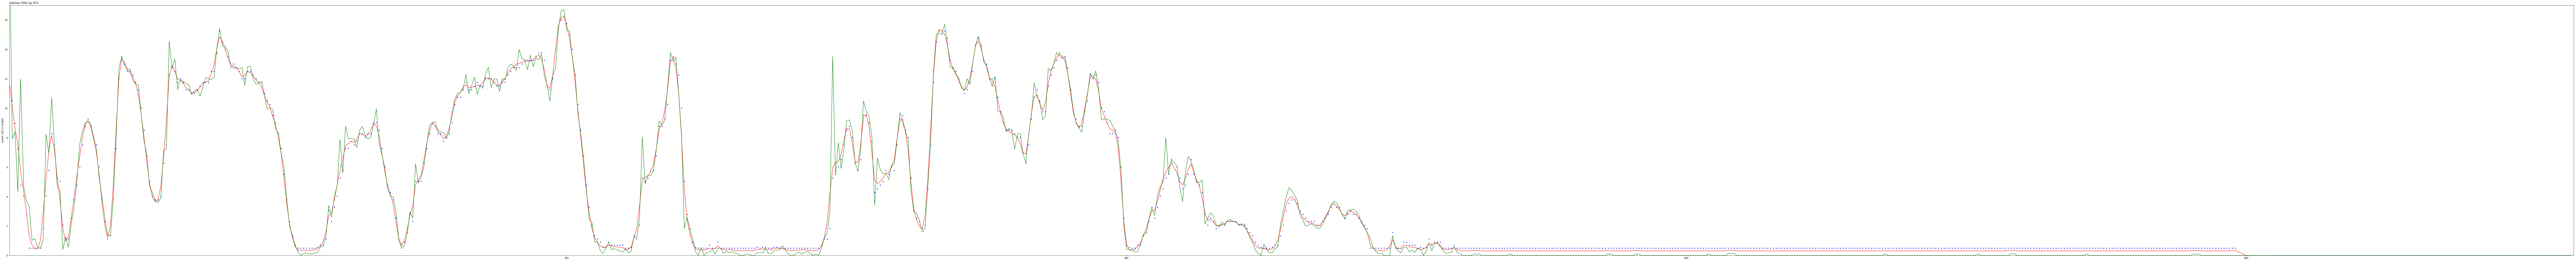

In [2]:
GPS_DATA_COLUMNS = ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gps_accuracy',
                'gps_bearing', 'gps_height', 'gps_lat', 'gps_lon', 'gps_speed']
TRIP_START_SPEED_KPH = 8.
lat_var = "gps_lat"
lon_var = "gps_lon"
time_var = "timestamp"
gps_speed_var = "gps_speed"
gps_accruacy_var = "gps_accuracy"
gpsdf = pd.read_csv('FLOOW_trip_data/b93de778-3a31-4e4e-8026-0cb87443976c.19sep2013170729.csv',index_col=False)

# Create time, distance and other variables
gpsdf.dropna(axis=0, how='any', subset=[lat_var, lon_var, gps_speed_var], inplace=True)
gpsdf[time_var] = gpsdf[time_var].astype(np.float64)
gpsdf[time_var] = gpsdf[time_var] / 1000.

# plot
xs, Ps, Ks = kalman_filter_on_gpsdata(gpsdf,
                            lat_var="gps_lat",
                            lon_var="gps_lon",
                            time_var="timestamp",
                            speed_var="gps_speed")
# % timeit xs, Ps, Ks = kalman_filter_on_gpsdata(gpsdf) 2.51 seconds for 7900 records
t = gpsdf[time_var].values[1:] - gpsdf[time_var].values[0]
fig, (ax0)=plt.subplots(nrows=1, sharex=True, figsize=(200,20))
ax0.set_ylabel('speed, x[t] vs xhat[t]')
ax0.plot(t, gpsdf["gps_speed"].values[1:], 'b.', t, xs[:,1], 'r-', t, add_speed(gpsdf)[1:], 'g-')
ax0.set_title("Kalman Fitler by RTS", loc="left")
ax0.set_xlim(int(np.min(t)),int(np.nanmax(t))+1)
ax0.set_ylim(0,int(np.nanmax(np.hstack((gpsdf["gps_speed"].values,xs[:,1]))))+1)
plt.show()

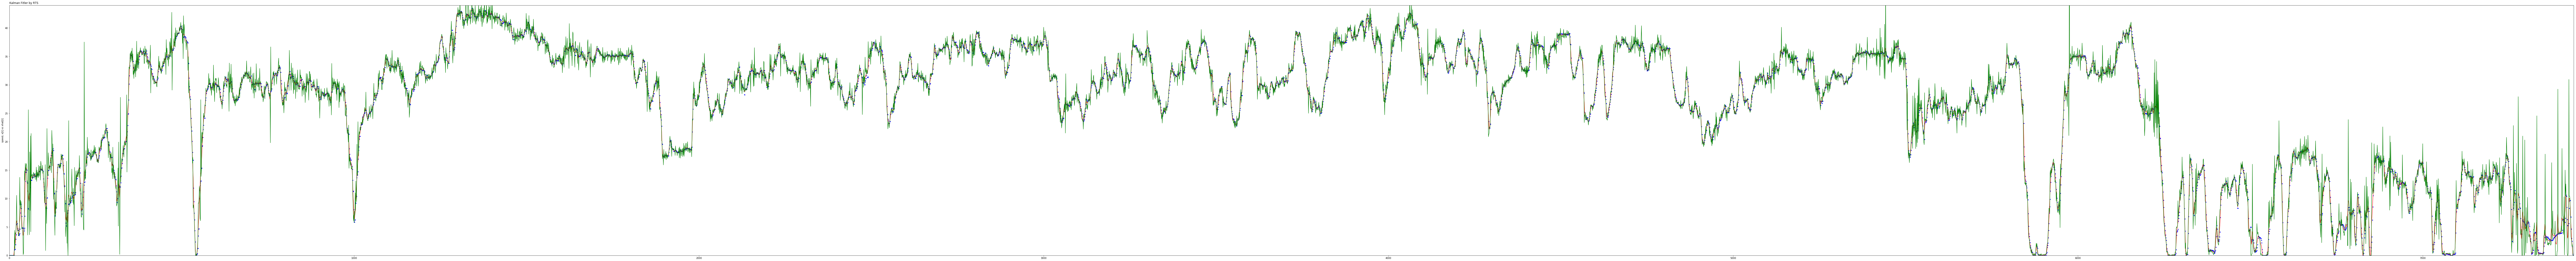

In [3]:
gpsdf = pd.read_csv('FLOOW_trip_data/1D2DC1C0-992E-417A-A7FF-C631CD255162.201309050539130000.csv',index_col=False)

# Create time, distance and other variables
gpsdf.dropna(axis=0, how='any', subset=[lat_var, lon_var, gps_speed_var], inplace=True)
gpsdf[time_var] = gpsdf[time_var].astype(np.float64)
gpsdf[time_var] = gpsdf[time_var] / 1000.

# plot
xs, Ps, Ks = kalman_filter_on_gpsdata(gpsdf,
                            lat_var="gps_lat",
                            lon_var="gps_lon",
                            time_var="timestamp",
                            speed_var="gps_speed")
# % timeit xs, Ps, Ks = kalman_filter_on_gpsdata(gpsdf) 2.51 seconds for 7900 records
t = gpsdf[time_var].values[1:] - gpsdf[time_var].values[0]
fig, (ax0)=plt.subplots(nrows=1, sharex=True, figsize=(200,20))
ax0.set_ylabel('speed, x[t] vs xhat[t]')
ax0.plot(t, gpsdf["gps_speed"].values[1:], 'b.', t, xs[:,1], 'r-', t, add_speed(gpsdf)[1:], 'g-')
ax0.set_title("Kalman Fitler by RTS", loc="left")
ax0.set_xlim(int(np.min(t)),int(np.nanmax(t))+1)
ax0.set_ylim(0,int(np.nanmax(np.hstack((gpsdf["gps_speed"].values,xs[:,1]))))+1)
plt.show()

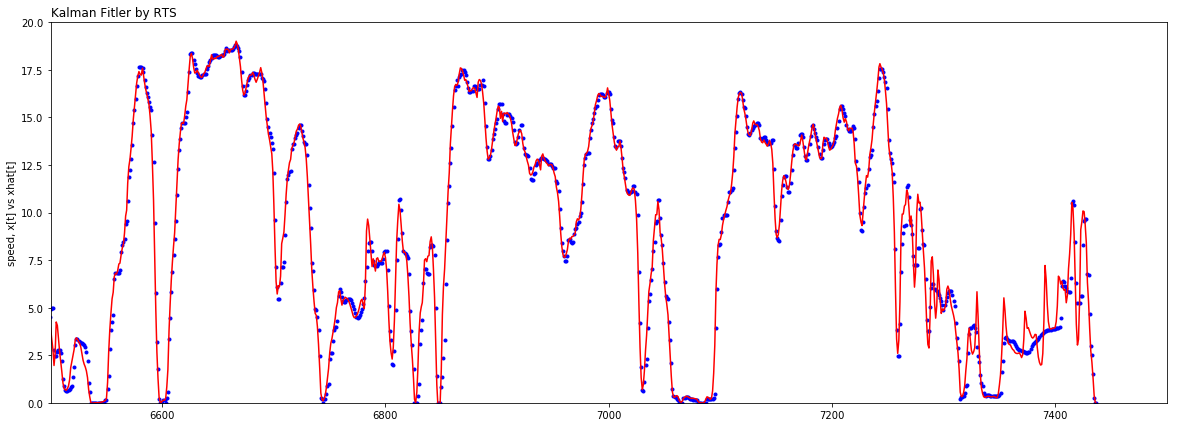

In [4]:
fig, (ax0)=plt.subplots(nrows=1, sharex=True, figsize=(20,7))
ax0.set_ylabel('speed, x[t] vs xhat[t]')
ax0.plot(t, gpsdf["gps_speed"].values[1:], 'b.', t, xs[:,1], 'r-')
ax0.set_title("Kalman Fitler by RTS", loc="left")
ax0.set_xlim(6500, 7500)
ax0.set_ylim(0,20)
plt.show()

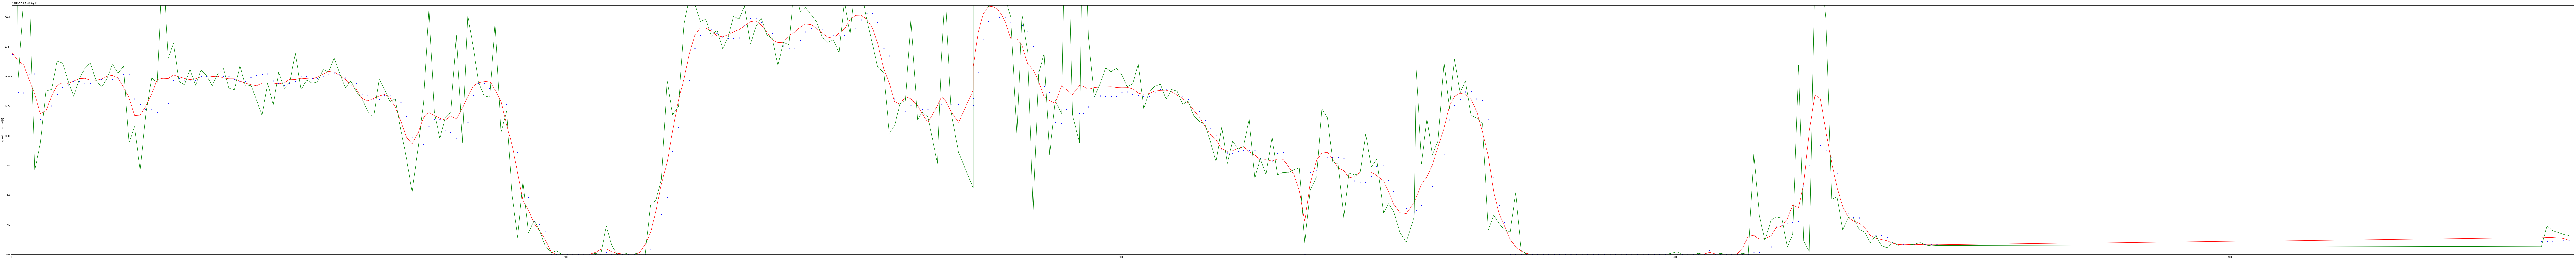

In [5]:
gpsdf = pd.read_csv('FLOOW_trip_data/1616D3D1-AC92-4C0D-B46A-39D75CDBBC7E.201308210454540000.csv',index_col=False)

# Create time, distance and other variables
gpsdf.dropna(axis=0, how='any', subset=[lat_var, lon_var, gps_speed_var], inplace=True)
gpsdf[time_var] = gpsdf[time_var].astype(np.float64)
gpsdf[time_var] = gpsdf[time_var] / 1000.

# plot
xs, Ps, Ks = kalman_filter_on_gpsdata(gpsdf,
                            lat_var="gps_lat",
                            lon_var="gps_lon",
                            time_var="timestamp",
                            speed_var="gps_speed")
# % timeit xs, Ps, Ks = kalman_filter_on_gpsdata(gpsdf) 2.51 seconds for 7900 records
t = gpsdf[time_var].values[1:] - gpsdf[time_var].values[0]
fig, (ax0)=plt.subplots(nrows=1, sharex=True, figsize=(200,20))
ax0.set_ylabel('speed, x[t] vs xhat[t]')
ax0.plot(t, gpsdf["gps_speed"].values[1:], 'b.', t, xs[:,1], 'r-', t, add_speed(gpsdf)[1:], 'g-')
ax0.set_title("Kalman Fitler by RTS", loc="left")
ax0.set_xlim(int(np.min(t)),int(np.nanmax(t))+1)
ax0.set_ylim(0,int(np.nanmax(np.hstack((gpsdf["gps_speed"].values,xs[:,1]))))+1)
plt.show()